In [63]:
%cd ..

c:\Users


In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Fitting Module
import lmfit
from lmfit.models import gaussian2d

# Image Processing Module
import imageio
import matplotlib.pyplot as plt

import scipy.ndimage

from src.functions.math import func as mathf
from src.functions.optics import func as optf
from src.constants import const

In [210]:
def getBeamWaist(img, img_bg):
    #input: image data as a 2D Matrix
    #output: image data,x-center point,y-center point, x-waist, y-waist, fit
    #Note: all position outputs are in pixel

    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    if img_bg == None:
        img_res = np.abs(np.array(img, dtype=float))
    else:
        img_res = np.abs(np.array(img, dtype=float) - np.array(img_bg, dtype=float))
    
    x_data = np.max(img_res, axis=0)
    y_data = np.max(img_res, axis=1)

    # also in /src/functions/math/func.py
    def GaussianWBaseline(x, center, sigma, amplitude, c_c):
        return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + c_c

    model = lmfit.Model(GaussianWBaseline)

    # adjust the initial parameters if needed
    params_x = model.make_params(c_c=0, center=np.argmax(x_data), sigma=50, amplitude=np.max(x_data))
    params_y = model.make_params(c_c=0, center=np.argmax(y_data), sigma=50, amplitude=np.max(y_data))

    # Set constraints if needed
    params_x['sigma'].set(max=3)
    # params_x['sigma'].set(min=50)
    params_y['sigma'].set(max=3)
    # params_y['sigma'].set(min=50)
    # params_x['amplitude'].set(min=15)
    # params_y['amplitude'].set(min=0)
    # params_x['center'].set(min=1500)
    # params_x['center'].set(max=2200)
    # params_x['c_c'].set(max=20)
    # params_y['c_c'].set(max=20)
    result_x = model.fit(x_data, params_x, x=x_rg)
    result_y = model.fit(y_data, params_y, x=y_rg)

    x_fit = result_x.best_fit
    y_fit = result_y.best_fit

    x0 = result_x.best_values['center']
    y0 = result_y.best_values['center']

    wx = 2 * result_x.best_values['sigma']
    wy = 2 * result_y.best_values['sigma']

    return img_res, x0, y0, wx, wy, x_data, x_fit, y_data, y_fit

def plotFittedImage(img,img_bg=None,m=None, pixel=None):
    #input is .bmp image

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.set_facecolor('w')

    #Rotate the image at some angle
    angle = 15
    img = scipy.ndimage.rotate(img,angle)
    if img_bg:
        img_bg = scipy.ndimage.rotate(img_bg,angle)


    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    img_res, x0, y0, wx, wy, x_data, x_fit, y_data, y_fit = getBeamWaist(img, img_bg)

    axs[0].imshow(img_res, cmap='gray', vmin=0, vmax=255)

    # axs[0].set_xlim([0, img.shape[1]])
    # axs[0].set_ylim([0, img.shape[0]])
    axs[0].set_xlim([x0-20, x0+20])
    axs[0].set_ylim([y0-20, y0+20])
    
    axs[0].set_xlabel('Pixel')
    axs[0].set_ylabel('Pixel')

    axs[0].hlines(y0-wy, x0-wx, x0+wx, color='b', linestyles='dashed')
    axs[0].hlines(y0+wy, x0-wx, x0+wx, color='b', linestyles='dashed')
    axs[0].vlines(x0-wx, y0-wy, y0+wy, color='r', linestyles='dashed')
    axs[0].vlines(x0+wx, y0-wy, y0+wy, color='r', linestyles='dashed')

    axs[1].scatter(x_rg, x_data)
    axs[1].plot(x_rg, x_fit, 'r', label='x Fit')
    axs[1].scatter(y_rg, y_data)
    axs[1].plot(y_rg, y_fit, 'b', label='y Fit')
    axs[1].vlines(x0-wx, 0, 100, color='r', linestyles='dashed', label='x bounds')
    axs[1].vlines(x0+wx, 0, 100, color='r', linestyles='dashed')
    axs[1].vlines(y0-wy, 0, 100, color='b', linestyles='dashed', label='y bounds')
    axs[1].vlines(y0+wy, 0, 100, color='b', linestyles='dashed')

    axs[1].set_xlim([x0-20, x0+20])
    
    axs[1].set_xlabel('Pixel')
    axs[1].set_ylabel('Intensity')
    axs[1].legend()

    #pixel_size in mm
    pixel_size = 1.67e-3 
    wx_mm = pixel_size*wx
    wy_mm = pixel_size*wy

    if m:
        wx_mm = wx_mm/m
        wy_mm = wy_mm/m

    if pixel:
        fig.suptitle(f'wx = {wx:.2f} pixel, wy = {wy:.2f} pixel')
    else:
        fig.suptitle(f'wx = {wx_mm:.2f} mm, wy = {wy_mm:.2f} mm')


In [236]:
def plotImage(img,r_x,r_y,img_bg=None,m=None, pixel=None):
    #input is .bmp image

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    fig.set_facecolor('w')

    #Rotate the image at some angle
    angle = 15
    img = scipy.ndimage.rotate(img,angle)
    if img_bg:
        img_bg = scipy.ndimage.rotate(img_bg,angle)


    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    img_res, x0, y0, wx, wy, x_data, x_fit, y_data, y_fit = getBeamWaist(img, img_bg)

    axs[0].imshow(img_res, cmap='gray', vmin=0, vmax=255)
    wx = r_x
    wy = r_y

    # axs[0].set_xlim([0, img.shape[1]])
    # axs[0].set_ylim([0, img.shape[0]])
    axs[0].set_xlim([x0-20, x0+20])
    axs[0].set_ylim([y0-20, y0+20])
    
    axs[0].set_xlabel('Pixel')
    axs[0].set_ylabel('Pixel')

    axs[0].hlines(y0-wy, x0-wx, x0+wx, color='b', linestyles='dashed')
    axs[0].hlines(y0+wy, x0-wx, x0+wx, color='b', linestyles='dashed')
    axs[0].vlines(x0-wx, y0-wy, y0+wy, color='r', linestyles='dashed')
    axs[0].vlines(x0+wx, y0-wy, y0+wy, color='r', linestyles='dashed')

    axs[1].scatter(x_rg, x_data)
    # axs[1].plot(x_rg, x_fit, 'r', label='x Fit')
    
    # axs[1].plot(y_rg, y_fit, 'b', label='y Fit')
    axs[1].vlines(x0-wx, 0, 100, color='r', linestyles='dashed', label='x bounds')
    axs[1].vlines(x0+wx, 0, 100, color='r', linestyles='dashed')

    axs[1].set_xlim([x0-20, x0+20])
    
    
    axs[1].set_xlabel('Pixel')
    axs[1].set_ylabel('Intensity')
    axs[1].legend()

        
    axs[2].scatter(y_rg, y_data, color='orange')
    axs[2].vlines(y0-wy, 0, 100, color='b', linestyles='dashed', label='y bounds')
    axs[2].vlines(y0+wy, 0, 100, color='b', linestyles='dashed')

    axs[2].set_xlim([y0-20, y0+20])

    axs[2].set_xlabel('Pixel')
    axs[2].set_ylabel('Intensity')
    axs[2].legend()


    

    #pixel_size in mm
    pixel_size = 1.67e-3 
    wx_mm = pixel_size*wx
    wy_mm = pixel_size*wy

    if m:
        wx_mm = wx_mm/m
        wy_mm = wy_mm/m

    if pixel:
        fig.suptitle(f'rx = {wx:.2f} pixel, ry = {wy:.2f} pixel')
    else:
        fig.suptitle(f'rx = {wx_mm:.2f} mm, ry = {wy_mm:.2f} mm')


C:\Users\ybtwe\AppData\Local\Temp/ipykernel_860/969212756.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plotFittedImage(imageio.imread(file_path+file_name+".bmp"),img_bg=None,m=None,pixel=True)


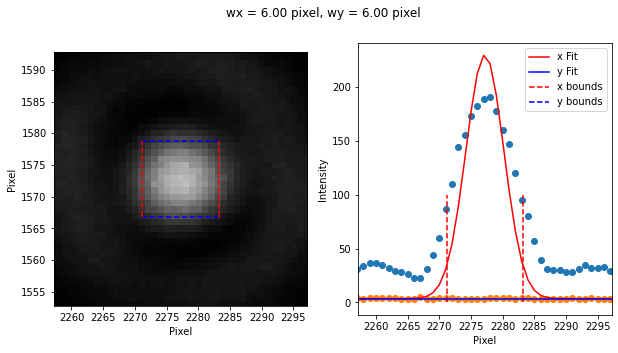

In [231]:
file_path = "C:/Users/ybtwe/OneDrive - University of Illinois - Urbana/Desktop/Tweezer/Post_objective/"
file_name = "Image__2024-05-14__post_2ndobj_9inch_1"
plotFittedImage(imageio.imread(file_path+file_name+".bmp"),img_bg=None,m=None,pixel=True)

C:\Users\ybtwe\AppData\Local\Temp/ipykernel_860/3625762787.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plotFittedImage(imageio.imread(file_path+file_name+".bmp"),img_bg=None,pixel=True)


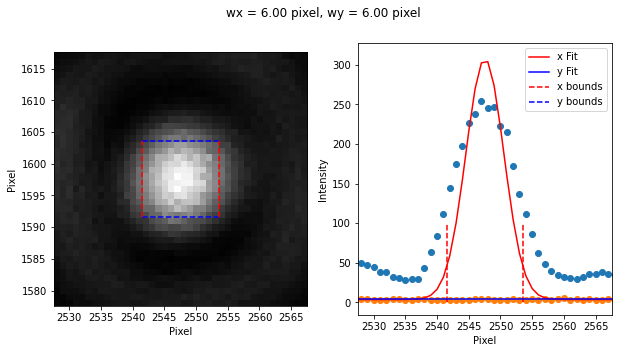

In [212]:
file_path = "C:/Users/ybtwe/OneDrive - University of Illinois - Urbana/Desktop/Tweezer/Post_objective/"
file_name = "Image__2024-05-14__post_2ndobj_41inch_1"
plotFittedImage(imageio.imread(file_path+file_name+".bmp"),img_bg=None,pixel=True)

C:\Users\ybtwe\AppData\Local\Temp/ipykernel_860/538217248.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plotImage(imageio.imread(file_path+file_name+".bmp"),10,9,img_bg=None,m=None,pixel=True)


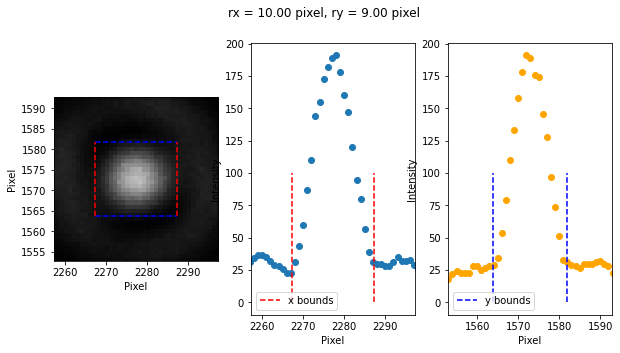

In [237]:
file_path = "C:/Users/ybtwe/OneDrive - University of Illinois - Urbana/Desktop/Tweezer/Post_objective/"
file_name = "Image__2024-05-14__post_2ndobj_9inch_1"
plotImage(imageio.imread(file_path+file_name+".bmp"),10,9,img_bg=None,m=None,pixel=True)

C:\Users\ybtwe\AppData\Local\Temp/ipykernel_860/176633826.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plotImage(imageio.imread(file_path+file_name+".bmp"),11,11,img_bg=None,m=None,pixel=True)


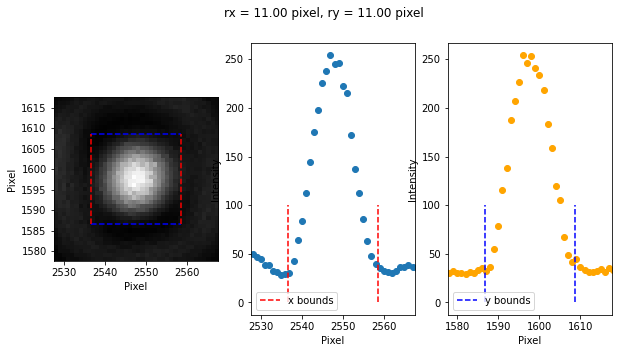

In [238]:
file_path = "C:/Users/ybtwe/OneDrive - University of Illinois - Urbana/Desktop/Tweezer/Post_objective/"
file_name = "Image__2024-05-14__post_2ndobj_41inch_1"
plotImage(imageio.imread(file_path+file_name+".bmp"),11,11,img_bg=None,m=None,pixel=True)